2025-04-12 08:03:44.978703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744445025.191866      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744445025.245945      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1744445099.229560      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744445111.732832      90 service.cc:148] XLA service 0x7bdafc113590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744445111.733685      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744445112.630384      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/107 ━━━━━━━━━━━━━━━━━━━━ 26:28 15s/step - accuracy: 0.1250 - loss: 2.2558

I0000 00:00:1744445117.057513      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 55s 382ms/step - accuracy: 0.3210 - loss: 1.7356 - val_accuracy: 0.6838 - val_loss: 0.9308
Epoch 2/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.6417 - loss: 0.9618 - val_accuracy: 0.7753 - val_loss: 0.6833
Epoch 3/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - accuracy: 0.7029 - loss: 0.7774 - val_accuracy: 0.7794 - val_loss: 0.6041
Epoch 4/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 278ms/step - accuracy: 0.7623 - loss: 0.6600 - val_accuracy: 0.8034 - val_loss: 0.5388
Epoch 5/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.7740 - loss: 0.5971 - val_accuracy: 0.8426 - val_loss: 0.4672
Epoch 6/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 277ms/step - accuracy: 0.7980 - loss: 0.5462 - val_accuracy: 0.8440 - val_loss: 0.4373
Epoch 7/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.8057 - loss: 0.5254 - val_accuracy: 0.8440 - val_loss: 0.4305
Epoch 8/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.8122 - loss: 0.4955 - val

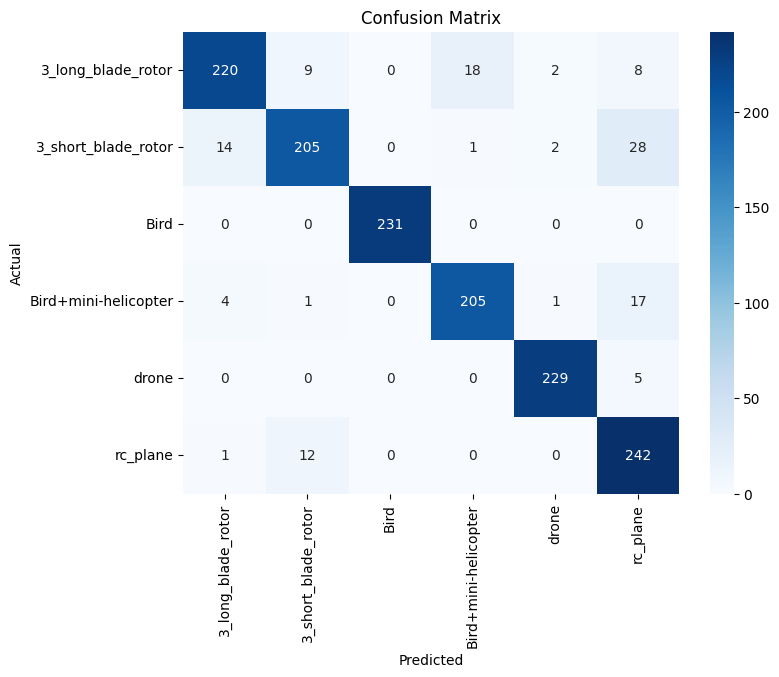

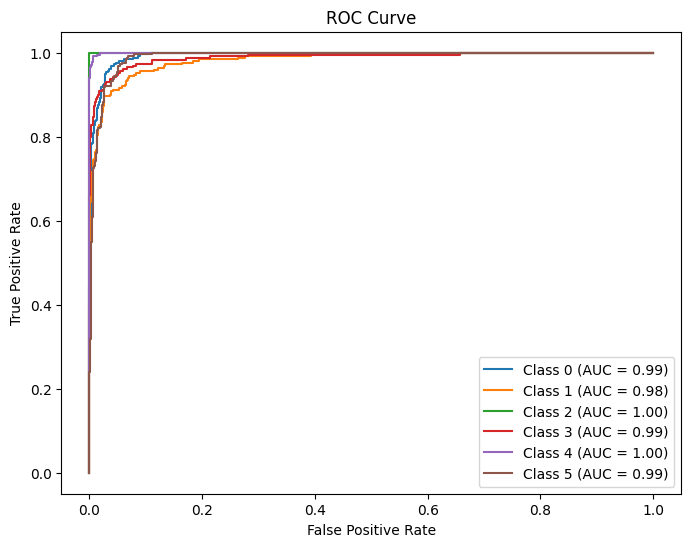

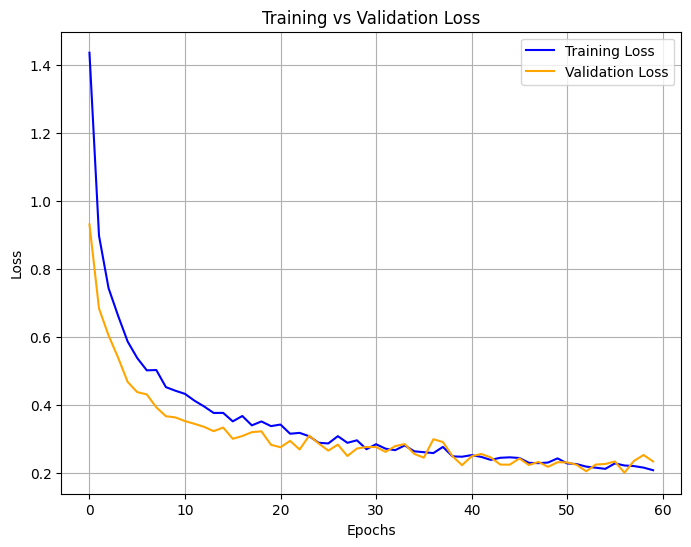

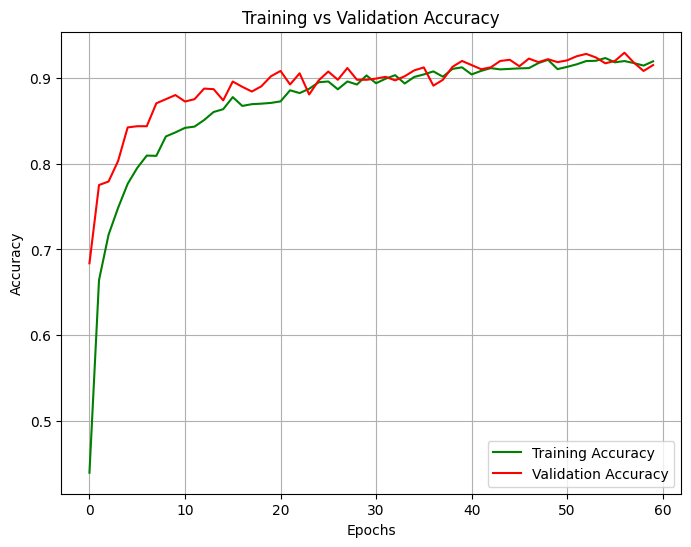

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2  # Switched to MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Category Mapping
categories = {
    '3_long_blade_rotor': 0,
    '3_short_blade_rotor': 1,
    'Bird': 2,
    'Bird+mini-helicopter': 3,
    'drone': 4,
    'rc_plane': 5
}

# Load & Preprocess Images
def load_images_from_folder(folder):
    images, labels = [], []
    for category, label in categories.items():
        category_folder = os.path.join(folder, category)
        if not os.path.exists(category_folder):
            print(f"Warning: {category_folder} does not exist!")
            continue
        for filename in os.listdir(category_folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = load_img(os.path.join(category_folder, filename), target_size=(224, 224))
                    images.append(img_to_array(img) / 255.0)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

dataset_path = "/kaggle/input/micro-doppler-dataset/new1"
X, y = load_images_from_folder(dataset_path)
y = to_categorical(y, num_classes=6)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Build MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Better for MobileNetV2 than Flatten
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile Model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=60, validation_data=(X_test, y_test))

# Save Model
model.save("mobilenetv2_micro_doppler.h5")

# Evaluate Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=categories.keys(), output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=categories.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories.keys(), yticklabels=categories.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(6):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
